Srihari Ponakala

50560580

Computer Vision And Image Processing Project

Title: Digital Image Tampering Detection

In [1]:
#importing All necessary modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [12]:
import opendatasets as od

In [13]:
dataset = "https://www.kaggle.com/datasets/sophatvathana/casia-dataset"

In [14]:
od.download(dataset)

Skipping, found downloaded files in ".\casia-dataset" (use force=True to force download)


In [92]:
dataset_dir = "./casia-dataset"
os.listdir(dataset_dir)

['casia', 'CASIA1', 'CASIA2']

Function to Convert Input image into Error Level Analysis(ELA). A digital image forensic technique used to identify areas of an image that have been digitally modified or altered.

In [91]:
def convert_to_ela_image(image_path, compression_quality=90):
    temp_jpeg_path = 'compressed_temp.jpg'
    original = Image.open(image_path).convert('RGB')
    original.save(temp_jpeg_path, 'JPEG', quality=compression_quality)
    
    compressed = Image.open(temp_jpeg_path)
    diff_image = ImageChops.difference(original, compressed)

    max_pixel_diff = max(value for _, value in diff_image.getextrema())
    if max_pixel_diff == 0:
        max_pixel_diff = 1

    scale_factor = 255.0 / max_pixel_diff
    ela_result = ImageEnhance.Brightness(diff_image).enhance(scale_factor)

    return ela_result

Config class for storing paths, hyperparameters, and model settings for image forgery detection.
Centralizing training config (batch size, LR, epochs) and dataset paths (Authentic /Tampered) for easy tuning.

In [31]:
class Config:
    au = "casia-dataset/CASIA2/Au"
    tp = "casia-dataset/CASIA2/Tp"
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 32
    lr = 1e-3
    name = 'xception'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

Computing Error Level Analysis (ELA) for image forensics by comparing original and compressed versions.
And Returning a difference map scaled by 15 which highlights potential tampered regions in JPEG images.

In [32]:
def compute_ela_cv(path, quality):
    temp_name = 'temp_name.jpg'
    SCALE = 15
    original_img = cv2.imread(path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(temp_name, original_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imread(temp_name)
    diff = SCALE * cv2.absdiff(original_img, compressed_img)
    return diff

In [33]:
# selecting random authentic or tampered images for forensic analysis during testing.
# Enabling unbiased sampling of dataset files to validate tampering detection models.
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

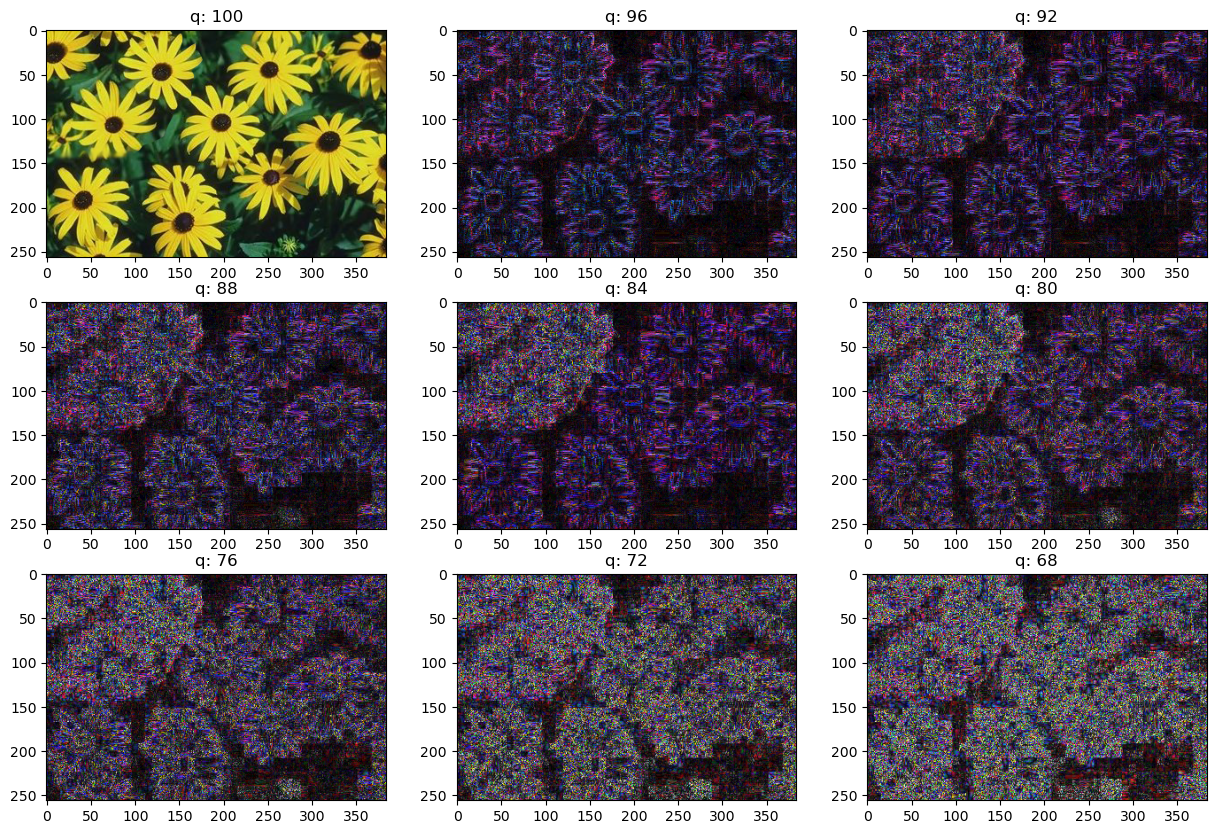

In [34]:
import cv2
from os.path import join, exists, isdir
from pathlib import Path
import random
p = join(Config.tp)
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 4
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

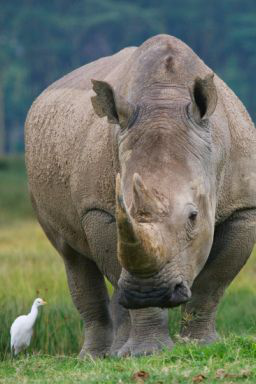

In [35]:
au_image_path = 'casia-dataset/CASIA2/Au/Au_ani_00092.jpg'
Image.open(au_image_path)

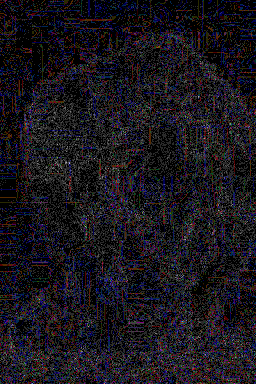

In [36]:
convert_to_ela_image(au_image_path, 91)

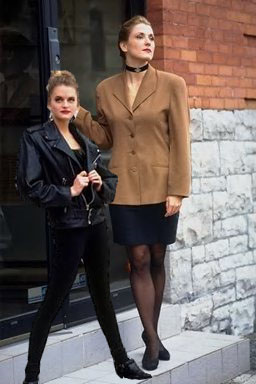

In [38]:
tamp_image_path = 'casia-dataset/CASIA2/Tp/Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg'
Image.open(tamp_image_path)

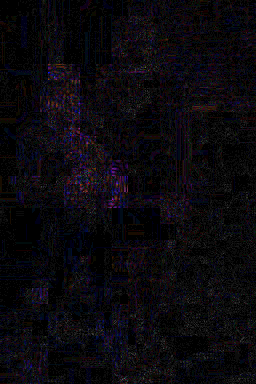

In [39]:
convert_to_ela_image(tamp_image_path, 91)

In [40]:
image_size = (128, 128)

In [41]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 91).resize(image_size)).flatten() / 255.0

In [42]:
X = []
Y = []
import random
path = Config.au
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 1000 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 1000 images
Processing 2000 images
Processing 3000 images
Processing 4000 images
Processing 5000 images
Processing 6000 images
Processing 7000 images
7354 7354


In [43]:
path = Config.tp
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 1000 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 8000 images
Processing 9000 images
Processing 10000 images
Processing 11000 images
Processing 12000 images
12477 12477


In [44]:
import numpy as np
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [45]:
X_t, X_test, Y_t, Y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_t, Y_t, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print("Test images\t\t", len(X_test), len(Y_test))
print("Train images\t\t", len(X_train), len(Y_train))
print("Validation images\t", len(X_val), len(Y_val))

Test images		 1248 1248
Train images		 8983 8983
Validation images	 2246 2246


In [46]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [50]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
epochs = 25
batch_size = 32
init_lr = 1e-4

optimizer = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [52]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val))

Epoch 1/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 162s 571ms/step - accuracy: 0.7280 - loss: 0.4817 - val_accuracy: 0.8887 - val_loss: 0.3062
Epoch 2/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 155s 551ms/step - accuracy: 0.8872 - loss: 0.3113 - val_accuracy: 0.8918 - val_loss: 0.2779
Epoch 3/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 159s 565ms/step - accuracy: 0.9009 - loss: 0.2696 - val_accuracy: 0.9056 - val_loss: 0.2474
Epoch 4/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 162s 576ms/step - accuracy: 0.9046 - loss: 0.2599 - val_accuracy: 0.9056 - val_loss: 0.2425
Epoch 5/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 157s 560ms/step - accuracy: 0.9230 - loss: 0.2145 - val_accuracy: 0.9061 - val_loss: 0.2266
Epoch 6/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 157s 560ms/step - accuracy: 0.9213 - loss: 0.2140 - val_accuracy: 0.9074 - val_loss: 0.2264
Epoch 7/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 155s 551ms/step - accuracy: 0.9174 - loss: 0.2065 - val_accuracy: 0.9110 - val_loss: 0.2174
Epoch 8/25
281/281 ━━━━━━━━━━━━━━━━━━━━ 171s 607ms/step - accuracy: 0.9224 -

In [53]:
model.save('Cvip_image_tampering_detection.h5')
print("Model saved as Cvip_image_tampering_detection.h5")

Model saved as Cvip_image_tampering_detection.h5


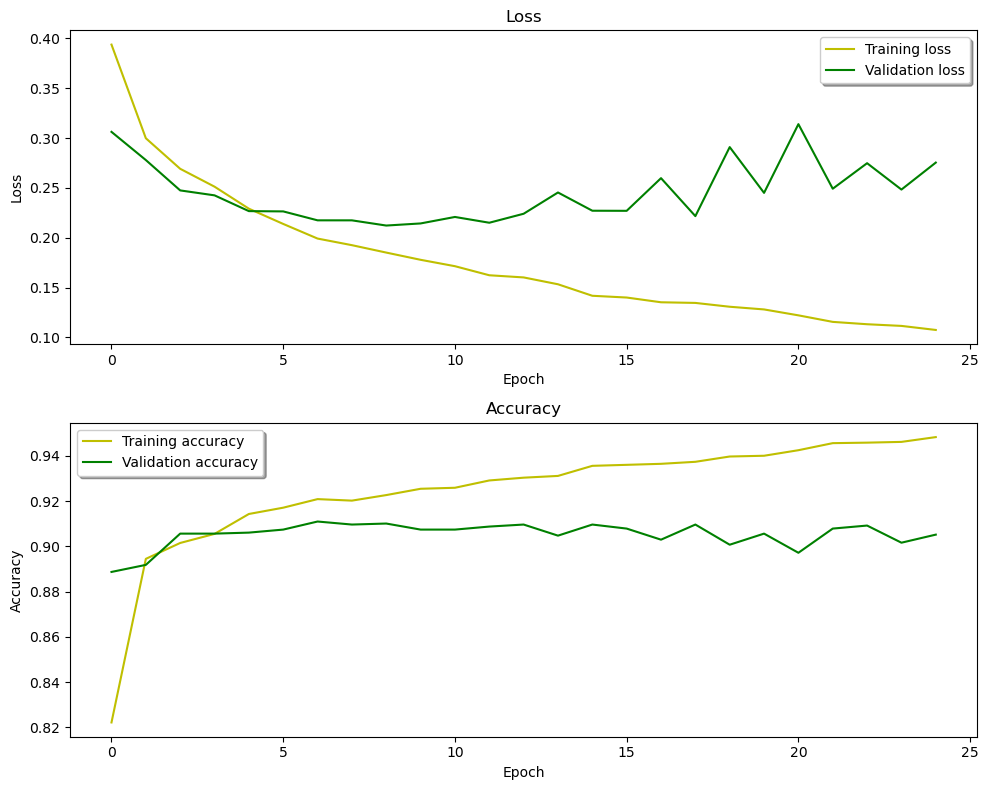

In [56]:
# Plotting the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plotting training and validation loss
ax[0].plot(hist.history['loss'], color='y', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='g', label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best', shadow=True)

# Plotting training and validation accuracy
ax[1].plot(hist.history['accuracy'], color='y', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='g', label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step


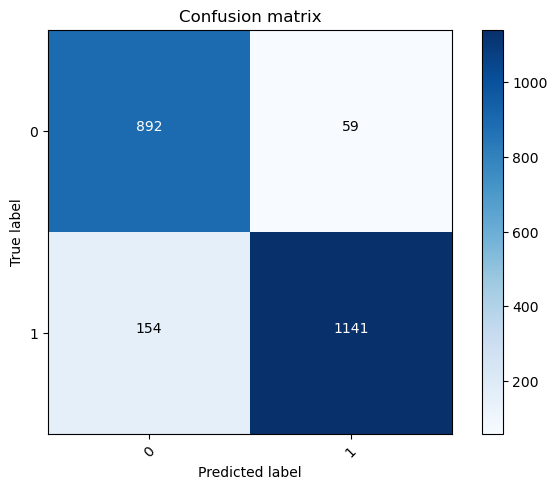

In [75]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plt.show(plot_confusion_matrix(confusion_mtx, classes = range(2)))

In [63]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Compute accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(Y_true, Y_pred_classes)
print("Precision:", precision)
print("_______________________________________")


# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes))

Accuracy: 0.9051647373107747
Precision: 0.9508333333333333
_______________________________________
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       951
           1       0.95      0.88      0.91      1295

    accuracy                           0.91      2246
   macro avg       0.90      0.91      0.90      2246
weighted avg       0.91      0.91      0.91      2246



39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


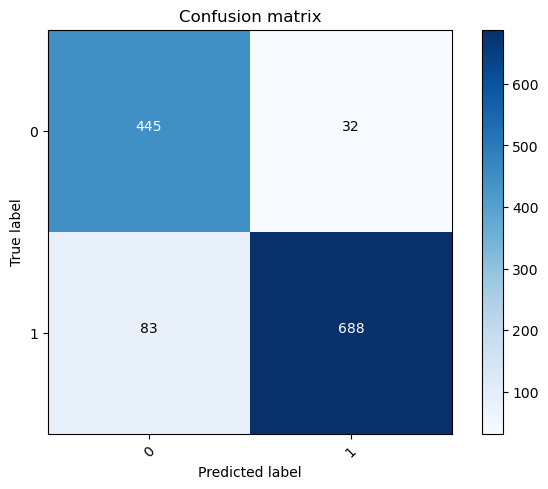

In [76]:
Y_pred = model.predict(X_test) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.show(plot_confusion_matrix(confusion_mtx, classes = range(2)))

In [68]:
def find_manipulated_region(ela, threshold=50):
    mask = np.array(ela) > threshold

    if np.any(mask):
        coords = np.argwhere(mask)
        return coords
    else:
        return None

In [69]:
def make_pixels_white(img, white_coords):
    width, height = img.size
    black_img = Image.new('RGB', (width, height), color='black')
    img_arr = np.array(img)
    black_arr = np.array(black_img)
    for coord in white_coords:
        x, y, z = coord
        black_arr[x,y,:] = [255,255,255]
    mask = np.all(black_arr == [255,255,255], axis=-1)
    img_arr[mask] = [255,255,255]
    new_img = Image.fromarray(img_arr)
    return new_img

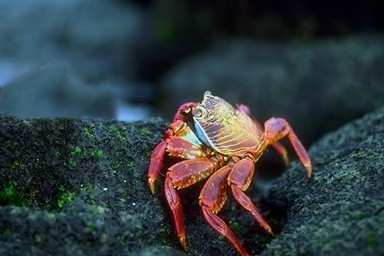

In [89]:
image_path = "casia-dataset/CASIA2/Tp/Tp_S_NNN_S_O_ani00011_ani00011_00835.tif"
Image.open(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Class: tampered


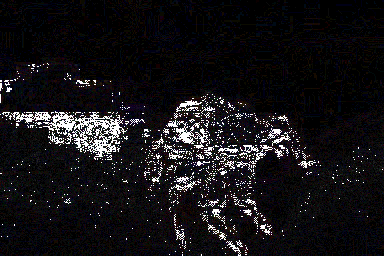

In [90]:
class_names = ['tampered', 'real']
image = prepare_image(image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]

if y_pred_class==0:
    print(f'Class: {class_names[y_pred_class]}')
    ela=convert_to_ela_image(image_path,91)
    coords=find_manipulated_region(ela)
    modify_boundary=make_pixels_white(ela,coords)
    display(modify_boundary)

else:
    print(f'Class: {class_names[y_pred_class]}, It is Real Image. No manipulations found')

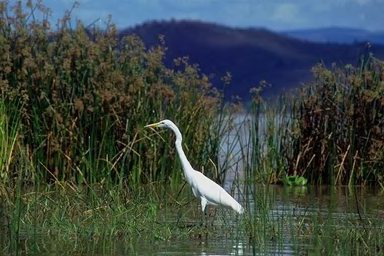

In [72]:
image_path = "casia-dataset/CASIA1/Au/Au_ani_0002.jpg"
Image.open(image_path)

In [73]:
class_names = ['tampered', 'real']
image = prepare_image(image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]

if y_pred_class==0:
    print(f'Class: {class_names[y_pred_class]}')
    ela=convert_to_ela_image(image_path,91)
    coords=find_manipulated_region(ela)
    modify_boundary=make_pixels_white(ela,coords)
    display(modify_boundary)

else:
    print(f'Class: {class_names[y_pred_class]}, It is Real Image. No manipulations found')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Class: real, It is Real Image. No manipulations found
